In [1]:
%load_ext autoreload
%autoreload 2

import optax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt

from pendulum_utils import get_simple_coordinates, get_rk_state_sequence
from pendulum_training import fit
from rff_gradients import lr_gradients, rp_gradients
from constants import RAND_KEY
from rff import get_zs

In [2]:
mu0 = jnp.array([jnp.pi / 4, 0.])
V0 = jnp.eye(2) * 0.00001

delta_t = 0.01
trans_noise = jnp.eye(2) * 0.001
obs_noise = jnp.eye(2) * 0.1

### Generate data points

In [3]:
num_steps = 2000
N = 100

states, observations, _ = get_rk_state_sequence(
    delta_t, mu0, V0, trans_noise, obs_noise, num_steps, N
)
sin_states = jnp.sin(states)
cos_states = jnp.cos(states)

xs, ys = get_simple_coordinates(states)

#### Angles as a function of time

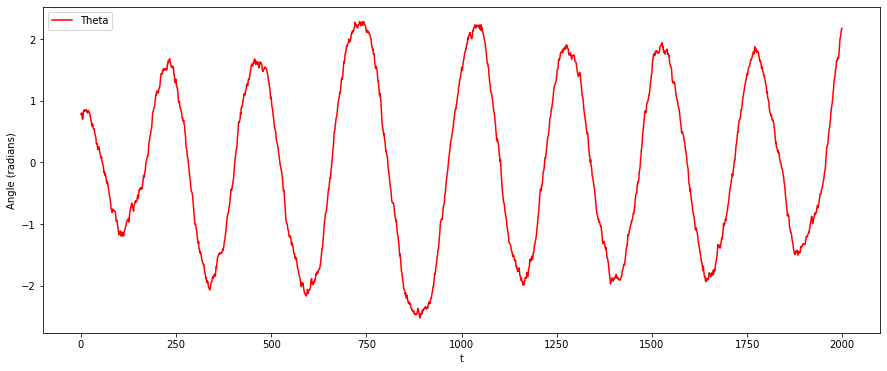

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(states[:, 0, 0], label="Theta", color='red')
plt.xlabel('t')
plt.ylabel('Angle (radians)')
plt.legend()
plt.savefig('pendulum_angle.jpg', bbox_inches='tight')
plt.show()

### Transition function of simple pendulum 

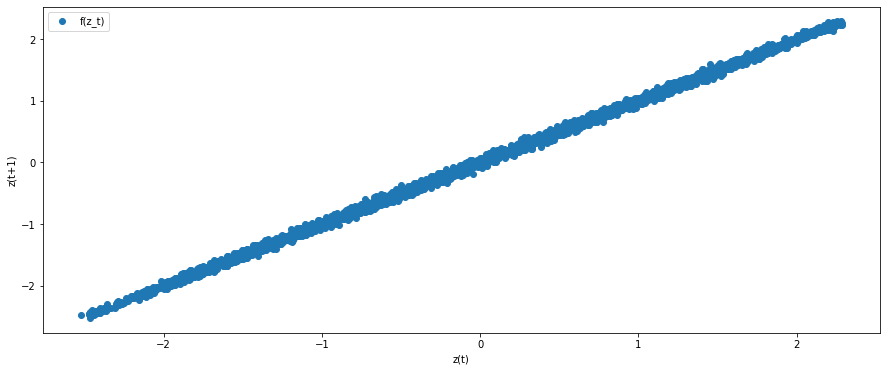

In [5]:
plt.figure(figsize=(15, 6))
plt.scatter(states[:-1, 0, 0], states[1:, 0, 0], label="f(z_t)")
plt.xlabel('z(t)')
plt.ylabel('z(t+1)')
plt.legend()
plt.savefig('pendulum_transitions.jpg', bbox_inches='tight')
plt.show()


#### Position of the mass at the end of the double pendulum

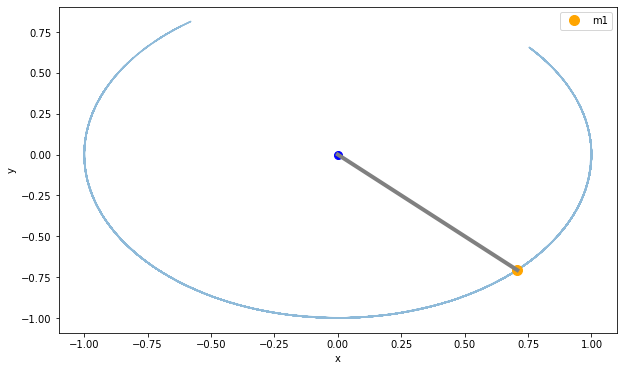

In [6]:
ox, oy = 0, 0
m1x, m1y = xs[0, 0], ys[0, 0]

plt.figure(figsize=(10,6))

plt.plot(xs[:4000, 0], ys[:4000, 0], alpha=0.5)

# Pendulum
plt.plot(ox, oy, 'bo', markersize=8)
plt.plot(m1x, m1y, 'o', color='orange', markersize=10, label='m1')
plt.plot([ox, m1x], [oy, m1y], linewidth=4, color='gray')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# plt.savefig('pendulum_coordinates.jpg')
plt.show()

### Random Fourier Features

In [15]:
lengthscale = .1
coef = 1. 
num_features = 5

num_steps = 2
N = 100000

trans_noise = jnp.eye(2) * 0.01
obs_noise = jnp.eye(2) * 0.1
V0 = jnp.eye(2)

get_cos_sin = lambda a: jnp.array([
    jnp.cos(a[0]),
    jnp.sin(a[0]),
    jnp.cos(a[1]),
    jnp.sin(a[1]),
])
start_state = jnp.array([jnp.pi / 4, 0.])

true_zs, xs, _ = get_rk_state_sequence(delta_t, start_state, V0, trans_noise, obs_noise, num_steps, N)

LR_ESTIMATOR = False
NUM_TRAINING_STEPS = 2000

start_weights = jnp.ones((num_features, start_state.shape[0]))
params = jnp.array([start_weights])


optimizer = optax.chain(
    optax.adam(learning_rate=0.006),
    optax.scale(-1.0)
)

optimizer.init(params)

learned_params, training_objectives, gradients = fit(
    params=params,
    optimizer=optimizer,
    training_steps=NUM_TRAINING_STEPS,
    num_features=num_features,
    lengthscale=lengthscale,
    coef=coef,
    V0=V0, 
    start_state=start_state,
    trans_noise=trans_noise,
    obs_noise=obs_noise,
    xs=xs,
    num_steps=num_steps,
    N=N,
    lr_estimator=LR_ESTIMATOR,
)

Step 0, marginal likelihood: -51.541519, A - [[0.994 0.994]
 [0.994 0.994]
 [0.994 0.994]
 [0.994 0.994]
 [0.994 0.994]]
Step 100, marginal likelihood: -43.669342, A - [[0.46867028 0.46896338]
 [0.4685031  0.46831086]
 [0.46896446 0.46836713]
 [0.4692597  0.46912268]
 [0.4690825  0.4686668 ]]
Step 200, marginal likelihood: -41.713039, A - [[0.16381162 0.16467208]
 [0.1637444  0.1633386 ]
 [0.16294108 0.16352198]
 [0.1640836  0.1637213 ]
 [0.16267377 0.16378777]]
Step 300, marginal likelihood: -41.466530, A - [[0.03971596 0.04111318]
 [0.04175449 0.03910402]
 [0.03988502 0.04047287]
 [0.04105888 0.04012597]
 [0.03996401 0.0407781 ]]
Step 400, marginal likelihood: -41.472229, A - [[0.00657549 0.0085648 ]
 [0.00879403 0.00815744]
 [0.00629197 0.00771473]
 [0.00646861 0.00692973]
 [0.00554991 0.00631015]]
Step 500, marginal likelihood: -41.363243, A - [[ 0.00076133  0.00143414]
 [-0.00080221  0.00116911]
 [ 0.00068735  0.00132333]
 [ 0.00027665 -0.00026864]
 [ 0.00071322  0.00132383]]
Step

KeyboardInterrupt: 

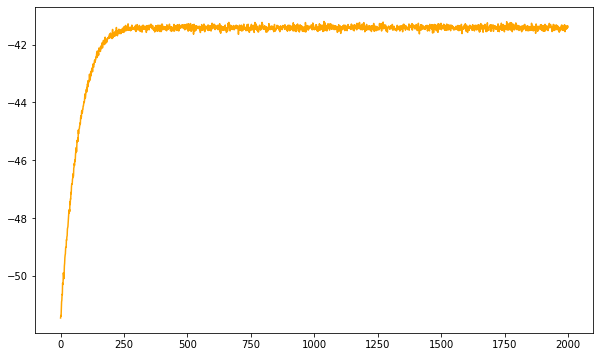

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(training_objectives, color='orange')
plt.show()

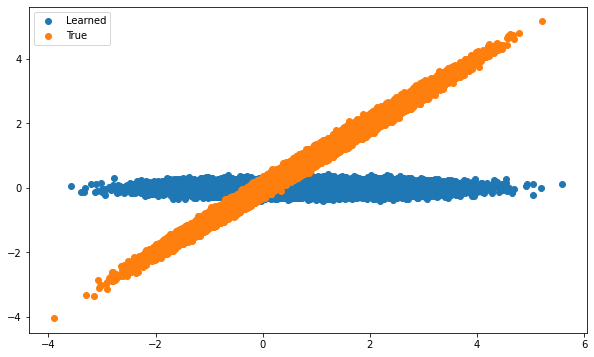

In [14]:
key=RAND_KEY
subkey = jrandom.split(key, num=3)
epsilons = jrandom.normal(key=subkey[0], shape=(num_steps, N, 2))
omegas = jrandom.normal(key=subkey[1], shape=(num_steps, num_features, N, 2))
phis = jrandom.uniform(key=subkey[2], minval=0, maxval=2 * jnp.pi, shape=(num_steps, num_features, N, 1))

states = get_zs(learned_params[0], num_features, lengthscale, coef, trans_noise, start_state, V0, omegas, phis, epsilons)


plt.figure(figsize=(10, 6))
plt.scatter(states[:-1, :, 0], states[1:, :, 0], label="Learned")
plt.scatter(true_zs[:-1, :, 0], true_zs[1:, :, 0], label="True")
plt.legend()
plt.show()

In [ ]:
weights = jnp.stack([
    jnp.full((num_features, 4), x, dtype=jnp.float32)
    for x in range(-5, 5)
])
N = 1000000
key = RAND_KEY
_, xs, _ = get_rk_state_sequence(delta_t, start_state, V0, trans_noise, obs_noise, num_steps, N)
for theta in weights:
    key, subkey = jrandom.split(key)

    epsilons = jrandom.normal(key=subkey, shape=(num_steps, N, 4))
    omegas = jrandom.normal(key=subkey, shape=(num_steps, num_features, N, xs.shape[-1]))
    phis = jrandom.uniform(key=subkey, minval=0, maxval=2 * jnp.pi, shape=(num_steps, num_features, N, 1))
    
    zs = get_zs(
        theta=theta,
        num_features=num_features,
        lengthscale=lengthscale,
        coef=coef,
        trans_noise=trans_noise,
        start_state=start_state, V0=V0,
        omegas=omegas, phis=phis,
        epsilons=epsilons,
    )
    
    lr_grads = lr_gradients(
        theta, xs, num_features, lengthscale, coef, trans_noise,
        obs_noise, start_state, V0, omegas, phis, zs, epsilons
    )
    rp_grads = rp_gradients(
        theta, xs, num_features, lengthscale, coef, trans_noise,
        obs_noise, start_state, V0, omegas, phis, epsilons
    )

    fig = plt.figure(figsize=(10, 6))
    ax = fig.subplots(1, 2)
    ax[0].plot(lr_grads[:, 0], label="LR")
    ax[1].plot(rp_grads[:, 0], label="RP", color='Orange')
    plt.legend()
    plt.show()

AssertionError: length mismatch: [2, 1]